# 21 MR results visualization R

**Origin:** `2_1_MR_results_viz_R.ipynb`  
**This annotated version was generated on:** 2025-10-13 06:41

**What this notebook does (high level):**  
- Visualize MR results in R: forest/scatter/funnel plots and multiple-testing–adjusted summaries.

**How to use:**  
1. Review the markdown notes before each code cell.  
2. Adjust input/output paths as needed for your environment.  
3. Run cell-by-cell to reproduce artifacts for downstream steps.

---


**Step 1:** Run a processing or analysis step.

In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(forcats)
# Optional: library(ggforestplot)

# Helper: compute 95% CI and odds ratio
ci_or <- function(b, se) {
  or  <- exp(b)
  lci <- exp(b - 1.96*se)
  uci <- exp(b + 1.96*se)
  return(data.frame(or=or, lci=lci, uci=uci))
}

setwd('/mnt/f/10_osteo_MR/results_mr_ptrs/')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




**Step 2:** Load tabular data (summary stats / annotations).

In [3]:
mr_eqtlgen <- fread("MR_result_eqtlgen_osteo.tsv")
method_main <- "Inverse variance weighted" # Change as needed

eqtlgen_top <- mr_eqtlgen %>%
  filter(method == method_main) %>%
  filter(method == method_main, pval < 0.05) %>%
  arrange(pval) %>%
  head(20) %>%
  mutate(rank = row_number())

cis <- ci_or(eqtlgen_top$b, eqtlgen_top$se)
eqtlgen_top <- bind_cols(eqtlgen_top, cis)

gg_eqtlgen <- ggplot(eqtlgen_top, aes(x=fct_reorder(gene, or), y=or)) +
  geom_pointrange(aes(ymin=lci, ymax=uci), color="#377eb8") +
  coord_flip() +
  #geom_text(aes(label=sprintf("p=%.1e", pval)), hjust=1.1, vjust=0.4, size=3) +
  geom_hline(yintercept=1, linetype="dashed") +
  theme_bw() +
  labs(title="MR: Top 10 genes (bulk, eQTLGen)",
       y="Odds ratio (95% CI)", x="Gene")
ggsave("MR_eqtlgen_bulk_top10.png", gg_eqtlgen, width=6, height=7)


**Step 3:** Load tabular data (summary stats / annotations).

In [13]:


library(data.table)
library(dplyr)

mr_eqtlgen <- fread("MR_result_pqtl_ukb_ppp_osteo.tsv")
alpha <- 0.05

# Function to filter significant genes by FDR for a method
sig_genes_by_method <- function(df, method_name, alpha = 0.05) {
  df_sub <- df %>% filter(method == method_name)
  if (nrow(df_sub) == 0) return(character())
  qval <- p.adjust(df_sub$pval, method = "fdr")
  df_sub <- df_sub %>% mutate(qval = qval)
  sig_genes <- df_sub %>% filter(qval < alpha) %>% pull(gene) %>% unique()
  return(sig_genes)
}

genes_ivw   <- sig_genes_by_method(mr_eqtlgen, "Inverse variance weighted", alpha)
genes_egger <- sig_genes_by_method(mr_eqtlgen, "MR Egger", alpha)
genes_wmed  <- sig_genes_by_method(mr_eqtlgen, "Weighted median", alpha)



**Step 4:** Visualization of results (figures/tables).

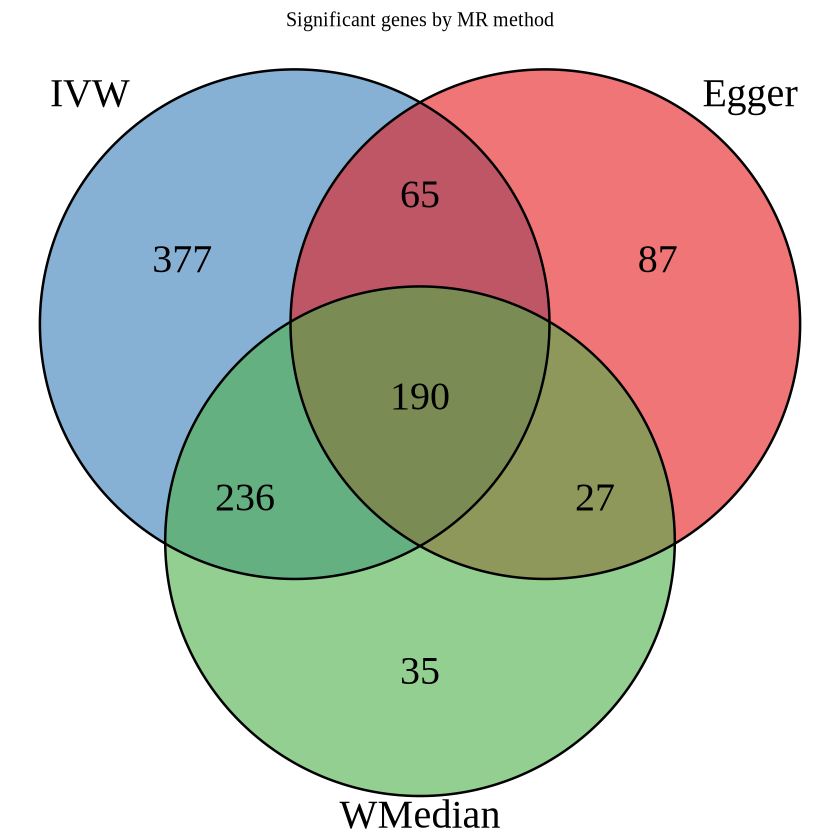

In [14]:
#install.packages("VennDiagram")
# or for pretty ggplot style:
#install.packages("ggvenn")
library(VennDiagram)
library(ggvenn)
library(data.table)
library(dplyr)


venn_list <- list(
  IVW = genes_ivw,
  Egger = genes_egger,
  WMedian = genes_wmed
)

# Using base VennDiagram package
venn.plot <- venn.diagram(
  venn_list,
  filename = NULL, # So we can plot to device
  fill = c("#377eb8", "#e41a1c", "#4daf4a"),
  alpha = 0.6,
  cex = 2,
  cat.cex = 2,
  main = "Significant genes by MR method"
)
grid.newpage()
grid.draw(venn.plot)

# Or for ggplot style (ggvenn):
gg_eqtlgen <- ggvenn(venn_list,
       fill_color = c("#377eb8", "#e41a1c", "#4daf4a"),
       show_percentage = FALSE,
       stroke_size = 0.5, set_name_size = 5,
       text_size = 5) +
  ggtitle("Significant genes by MR method")


ggsave("./venn/MR_pqtl_ukb_ppp_bulk.png", gg_eqtlgen, width=6, height=7)


**Step 5:** Process gene expression matrices / normalization.

In [2]:


# Version info: R 4.2.2, Biobase 2.58.0, GEOquery 2.66.0, limma 3.54.0
################################################################
#   Differential expression analysis with limma
library(GEOquery)
library(limma)
library(umap)

**Step 6:** Aggregate/group statistics across keys (genes/SNPs/cohorts).

Found 1 file(s)

GSE123568_series_matrix.txt.gz

Using locally cached version: /tmp/RtmpI34ZgD/GSE123568_series_matrix.txt.gz

Using locally cached version of GPL15207 found here:
/tmp/RtmpI34ZgD/GPL15207.soft.gz 



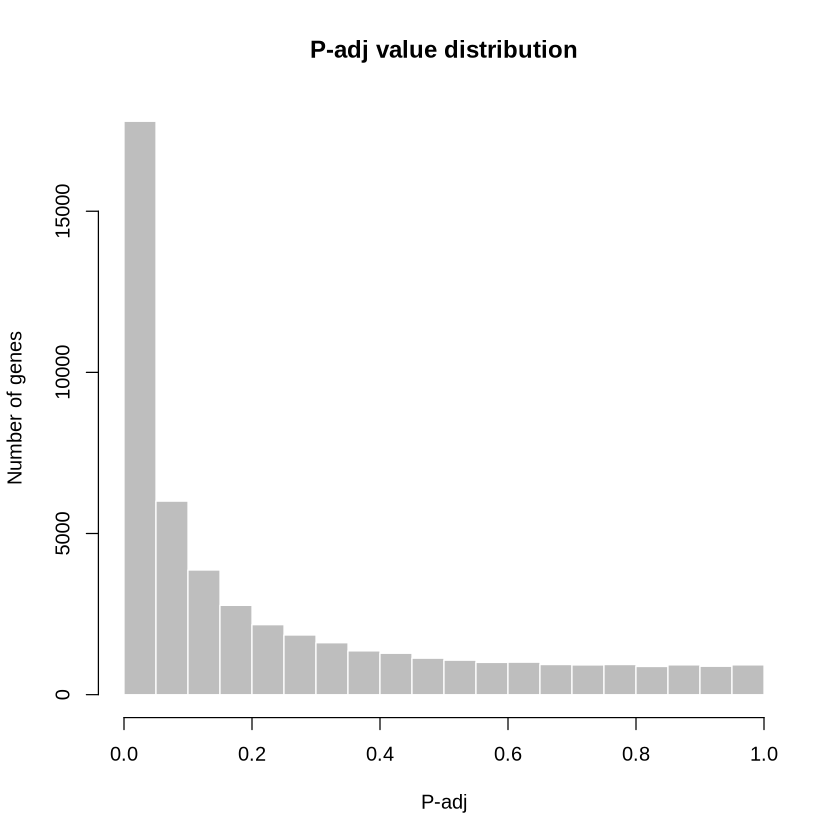

[1] "Control-Disease"

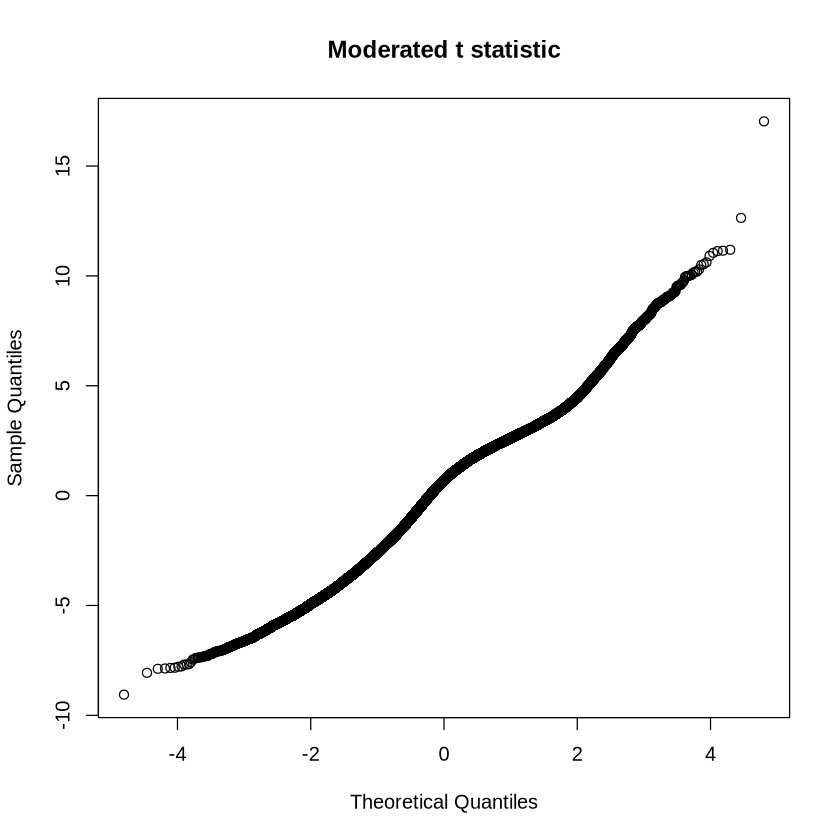

In [14]:

# load series and platform data from GEO

gset <- getGEO("GSE123568", GSEMatrix =TRUE, AnnotGPL=FALSE)
if (length(gset) > 1) idx <- grep("GPL15207", attr(gset, "names")) else idx <- 1
gset <- gset[[idx]]

# make proper column names to match toptable 
fvarLabels(gset) <- make.names(fvarLabels(gset))

# group membership for all samples
gsms <- "0000000000111111111111111111111111111111"
sml <- strsplit(gsms, split="")[[1]]

# log2 transformation
ex <- exprs(gset)
qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
LogC <- (qx[5] > 100) ||
          (qx[6]-qx[1] > 50 && qx[2] > 0)
if (LogC) { ex[which(ex <= 0)] <- NaN
  exprs(gset) <- log2(ex) }

# assign samples to groups and set up design matrix
gs <- factor(sml)
groups <- make.names(c("Control","Disease"))
levels(gs) <- groups
gset$group <- gs
design <- model.matrix(~group + 0, gset)
colnames(design) <- levels(gs)

gset <- gset[complete.cases(exprs(gset)), ] # skip missing values

fit <- lmFit(gset, design)  # fit linear model

# set up contrasts of interest and recalculate model coefficients
cts <- paste(groups[1], groups[2], sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

# compute statistics and table of top significant genes
fit2 <- eBayes(fit2, 0.01)
tT <- topTable(fit2, adjust="fdr", sort.by="B", number=250)

tT <- subset(tT, select=c("ID","adj.P.Val","P.Value","t","B","logFC","GB_ACC","GI","Gene.Symbol","SPOT_ID"))
# write.table(tT, file=stdout(), row.names=F, sep="\t")

# Visualize and quality control test results.
# Build histogram of P-values for all genes. Normal test
# assumption is that most genes are not differentially expressed.
tT2 <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)
hist(tT2$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
  ylab = "Number of genes", main = "P-adj value distribution")

# summarize test results as "up", "down" or "not expressed"
dT <- decideTests(fit2, adjust.method="fdr", p.value=0.05, lfc=0)

# Venn diagram of results
#vennDiagram(dT, circle.col=palette())

# create Q-Q plot for t-statistic
t.good <- which(!is.na(fit2$F)) # filter out bad probes
qqt(fit2$t[t.good], fit2$df.total[t.good], main="Moderated t statistic")

# volcano plot (log P-value vs log fold change)
colnames(fit2) # list contrast names
ct <- 1        # choose contrast of interest
# Please note that the code provided to generate graphs serves as a guidance to
# the users. It does not replicate the exact GEO2R web display due to multitude
# of graphical options.
# 
# The following will produce basic volcano plot using limma function:
#volcanoplot(fit2, coef=ct, main=colnames(fit2)[ct], pch=20,
#  highlight=length(which(dT[,ct]!=0)), names=rep('+', nrow(fit2)))

# MD plot (log fold change vs mean log expression)
# highlight statistically significant (p-adj < 0.05) probes
#plotMD(fit2, column=ct, status=dT[,ct], legend=F, pch=20, cex=1)
#abline(h=0)


**Step 7:** Visualization of results (figures/tables).

In [60]:

################################################################
# General expression data analysis
ex <- exprs(gset)

# box-and-whisker plot


#dev.new(width=3+ncol(gset)/6, height=5)

#pdf( file= "gene_expression", width = 7, height = 5) # Adjust width and height as needed

pdf("Fig2b_expr_boxplot.pdf", width = 8, height = 4) # Adjust width and height as needed


ord <- order(gs)  # order samples by group

palette(c("#1B9E77", "#7570B3", "#E7298A", "#E6AB02", "#D95F02",
          "#66A61E", "#A6761D", "#B32424", "#B324B3", "#666666"))
par(mar=c(7,4,2,1))
title <- paste ("GSE123568", "/", annotation(gset), sep ="")

boxplot(ex[,ord], boxwex=0.6, notch=T, main=title, outline=FALSE, las=2,
        ylim= c( 0, 15), col=gs[ord])


legend("topleft", groups, fill=palette(), bty="n")
dev.off()



pdf 
  2